In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os

os.environ['PYSPARK_SUBMIT_ARGS'] = '''--conf spark.driver.memory=60G \
                                       --conf spark.sql.shuffle.partitions=10 \
                                       --conf spark.default.parallelism=10 \
                                       --conf spark.hadoop.fs.s3a.readahead.range=512M \
                                       pyspark-shell'''

spark = (SparkSession
         .builder
         .master("local[*]")
         .getOrCreate())

In [2]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from functools import reduce

In [4]:
savep="s3a://midgar-aws-workspace/stg/shinra/modelling/journeyautomation/eval/pcgm-1977/classic/"

In [5]:
start_date='2020-04-20'
end_date='2020-05-20'

In [6]:
times = pd.date_range(start=start_date, end=end_date).to_pydatetime().tolist()
dates=[dt.strftime('%Y-%m-%d') for dt in times]

In [7]:
campaign_dates=['2020-05-19']

# Campaign meta

In [8]:
cmeta_path="s3a://midgar-aws-workspace/prod/mapmeasurements/redshift_backup/campaign_metadata/dt="

In [9]:
cm_map_dfs=map(lambda x: spark.read.parquet(cmeta_path+x)
            .select("campaign_id", 'campaign_name', "phase_id", "phase_name")
            .filter(F.col('phase_id').isNotNull()), 
               campaign_dates)

In [10]:
cm_red_df=reduce(lambda x,y: x.union(y), cm_map_dfs)

In [11]:
cm_red_df.printSchema()

root
 |-- campaign_id: string (nullable = true)
 |-- campaign_name: string (nullable = true)
 |-- phase_id: integer (nullable = true)
 |-- phase_name: string (nullable = true)



In [12]:
c_id_names = (cm_red_df.select("campaign_id", "campaign_name").distinct()
         .rdd.map(lambda x : (x[0],x[1])).collectAsMap())

# User distribution across campaigns

In [13]:
## data in ['2020-05-17', '2020-05-18', '2020-05-19']
path1="s3a://midgar-aws-workspace/prod/mapmeasurements/redshift_backup/push_campaigns_customer/dt=2020-05-19"


In [14]:
df1= spark.read.parquet(path1)

In [15]:
df1.select('scheduler').distinct().show(4, False)

+------------------------------------+
|scheduler                           |
+------------------------------------+
|manual                              |
|model-bus_inf_phase_inf_cat_affinity|
|classic                             |
|Old School                          |
+------------------------------------+



In [18]:
df_model=(df1.filter(F.col("scheduler") == "classic")
     .select("campaign_id", "customer_id"))

In [23]:
df_model.count()

46133514

## user selection

In [19]:
users = df_model.select("customer_id").distinct()#.randomSplit([0.2, 0.8], seed=522)[0]

In [20]:
#users.coalesce(5).write.mode('overwrite').parquet(savep+"selected_users")

In [21]:
users=spark.read.parquet(savep+"selected_users")

In [22]:
users.count()

29320475

## distribution

In [23]:
user_camp=(users.join(df_model, ["customer_id"]).groupby("campaign_id")
           .agg(F.countDistinct("customer_id").alias("count"))
           .sort(F.col("count").desc()))

In [14]:
user_camp.count()

100

In [24]:
#user_camp.coalesce(1).write.mode('overwrite').parquet(savep+"campaign_user_distribution")

In [25]:
user_camp=spark.read.parquet(savep+"campaign_user_distribution")

## entropy

In [26]:
from scipy.stats import entropy

In [27]:
user_camp_pdf=user_camp.toPandas().sort_values(by='count', ascending=False)

/opt/conda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


In [28]:
s = sum(user_camp_pdf['count'].to_numpy())
user_camp_pdf['p'] = user_camp_pdf['count']/s

In [29]:
entropy(user_camp_pdf['p'])

2.0566838279454847

## plot

In [30]:
def _plot(data, x, y, title):
    plt.figure(figsize=(16, 6))
    result = data.sort_values(y, ascending=False)
    ax = sns.barplot(x=x, y=y, data=data, order=result[x])
    ax.set_title(title)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

In [31]:
user_camp_pdf.head(20)

,campaign_id,count,p
0,97031,24183638,0.583658
1,96890,1689118,0.040766
2,96253,1483906,0.035813
3,96888,1313833,0.031709
4,95691,1248170,0.030124
5,96889,1196935,0.028887
6,96251,1123227,0.027108
7,96252,1026878,0.024783
8,86098,911453,0.021997
9,86137,903468,0.021805


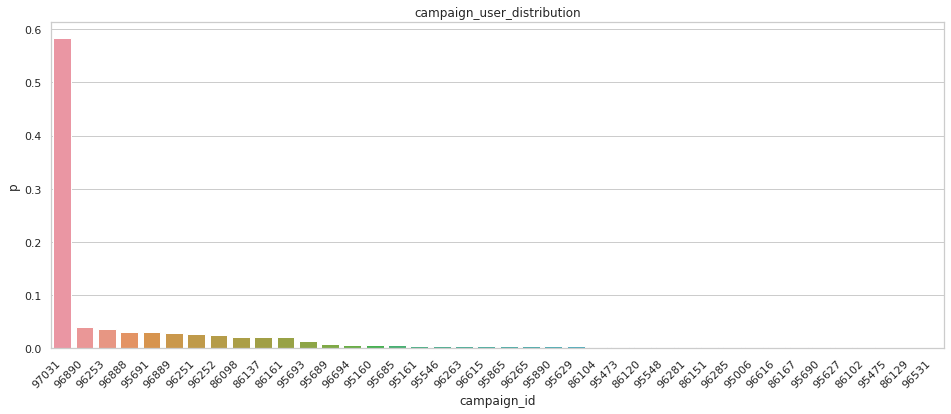

In [32]:
_plot(user_camp_pdf.head(40), 'campaign_id', 'p', 'campaign_user_distribution')

# User distribution across lifecycle phases

In [39]:
#user_campaign=users.join(df_model.select('customer_id', 'campaign_id'), on=['customer_id'])

In [33]:
user_phase_left=df_model.join(cm_red_df, on=['campaign_id']).select('customer_id', 'phase_id')

In [34]:
#user_phase_left.coalesce(10).write.mode('overwrite').parquet(savep+"/user_phase_left")

In [35]:
user_phase_left=spark.read.parquet(savep+"/user_phase_left")

In [36]:
user_phase=(user_phase_left.groupby("phase_id")
            .agg(F.count("customer_id").alias("count"))
            .sort(F.col("count").desc()))

In [37]:
#user_phase.coalesce(10).write.mode('overwrite').parquet(savep+"/user_phase")

In [38]:
user_phase=spark.read.parquet(savep+"user_phase")

## plot

In [39]:
user_phase_pdf=user_phase.toPandas().sort_values(by='count', ascending=False)

/opt/conda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


In [40]:
s = sum(user_phase_pdf['count'].to_numpy())
user_phase_pdf['p'] = user_phase_pdf['count']/s

In [41]:
user_phase_pdf.head()

,phase_id,count,p
0,1,41653352,0.907519
1,2,3826294,0.083365
2,4,277436,0.006045
3,3,140989,0.003072


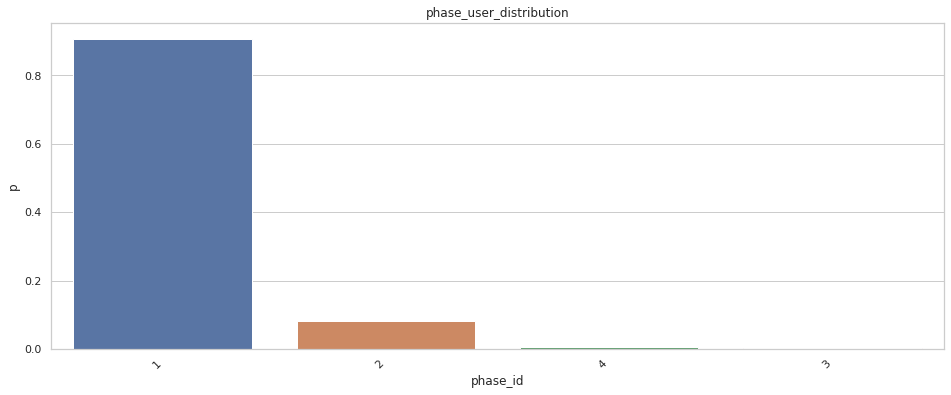

In [42]:
_plot(user_phase_pdf, 'phase_id', 'p', 'phase_user_distribution')

# Interactions

In [43]:
clicks_path="s3a://midgar-aws-workspace/prod/shinra/telescope/base/l1_banner_events_base_table/dt="

In [44]:
click_map_dfs=map(lambda x: users.join(spark.read.parquet(clicks_path+x)
                                       .select('customer_id', 'banner_clicks', 'sales').fillna(0), 
                                 on=['customer_id']), dates)

In [45]:
clikc_red_df=reduce(lambda x,y: x.union(y), click_map_dfs)

In [46]:
clikc_red_df.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- banner_clicks: long (nullable = true)
 |-- sales: long (nullable = true)



In [47]:
cnt_cond = lambda cond: F.sum(F.when(cond, 1).otherwise(0))

In [48]:
(clikc_red_df
 .agg(F.count('banner_clicks').alias('total'), (F.sum('banner_clicks')).alias('clicks'))
 .withColumn("click_rate", F.col('clicks') / F.col('total')).show())

+----------+--------+--------------------+
|     total|  clicks|          click_rate|
+----------+--------+--------------------+
|1156916692|58889420|0.050902040230914054|
+----------+--------+--------------------+



In [49]:
(clikc_red_df
 .agg(F.count('sales').alias('total'), (F.sum('sales')).alias('sales_count'))
 .withColumn("sales_rate", F.col('sales_count') / F.col('total')).show())

+----------+-----------+-------------------+
|     total|sales_count|         sales_rate|
+----------+-----------+-------------------+
|1156916692|   89647583|0.07748836508272974|
+----------+-----------+-------------------+



# RFM

In [50]:
bpath="s3a://midgar-aws-workspace/prod/mapfeatures/raw/baseTables/sales/dt="

In [51]:
map_dfs=map(lambda x: users.join(spark.read.parquet(bpath+x).select('customer_id', 'selling_price', 'created_at'), 
                                 on=['customer_id']), dates)

In [52]:
red_df=reduce(lambda x,y: x.union(y), map_dfs)

In [75]:
def rfm(df, start_date, end_date):
    
    from pyspark.sql.types import FloatType
    date_format_str ='yyyy-MM-dd'
    
    df_agg = (df.groupBy('customer_id')
                    .agg(
                        F.countDistinct('created_at').alias('frequency'),
                        F.avg('selling_price').cast(FloatType()).alias('monetary_value'),
                        F.sum('selling_price').cast(FloatType()).alias('total_value'),
                        F.max('created_at').alias('max_dt'),
                        F.min('created_at').alias('min_dt')
                    ).withColumn('last_date', F.lit(end_date))
    .withColumn('first_date', F.lit(start_date))
    .withColumn('recency', F.datediff(
                               F.date_add(F.to_date('last_date', date_format_str), 1),
                               F.to_date('max_dt', date_format_str)
                           ))
    )
    
    return df_agg.select(df_agg.customer_id, df_agg.frequency, df_agg.recency, 
                         df_agg.monetary_value, df_agg.total_value)

In [76]:
rfm_df=rfm(red_df, start_date ,end_date)

In [77]:
f99=rfm_df.approxQuantile('frequency', [0.99], 1e-5)[0]
rfm_df=rfm_df.filter(F.col('frequency') < f99)

In [78]:
m99=rfm_df.approxQuantile('total_value', [0.99], 1e-5)[0]
rfm_df=rfm_df.filter(F.col('total_value') < m99)

In [79]:
rfm_df.select('frequency',"recency", 'total_value').summary().show()

+-------+-----------------+-----------------+------------------+
|summary|        frequency|          recency|       total_value|
+-------+-----------------+-----------------+------------------+
|  count|         13891416|         13891416|          13891416|
|   mean|4.781737585282882|9.347670316690538|2657.6516657698276|
| stddev|4.699331827343079|8.173536489130123|  4577.54558560732|
|    min|                1|                1|               0.0|
|    25%|                2|                3|             298.0|
|    50%|                3|                7|             907.0|
|    75%|                6|               14|            2744.0|
|    max|               33|               31|          35402.34|
+-------+-----------------+-----------------+------------------+



In [88]:
rfm_df=rfm_df.withColumn('type', F.lit('classic'))

In [91]:
rfm_df.count()

13891416

In [109]:
rfm_df.coalesce(5).write.mode('overwrite').parquet(savep+"/rfm_df")

In [116]:
rfm_df.count()

15406695

## load model data

In [89]:
model_pdf=(spark
           .read
           .parquet("s3a://midgar-aws-workspace/stg/shinra/modelling/journeyautomation/eval/pcgm-1977/rfm_df"))

In [90]:
model_pdf.show(2,False)

+-----------+---------+-------+--------------+-----------+-----+
|customer_id|frequency|recency|monetary_value|total_value|type |
+-----------+---------+-------+--------------+-----------+-----+
|1000001077 |5        |7      |372.2         |1861.0     |model|
|1000003973 |2        |7      |219.0         |438.0      |model|
+-----------+---------+-------+--------------+-----------+-----+
only showing top 2 rows



## compare

In [159]:
#mixed_df=rfm_df.union(model_pdf)
mixed_df=spark.read.parquet(savep+"/rfm_df")
#mixed_df.count()

### spark bin

In [124]:
mixed_df.select('frequency',"recency", 'total_value').summary().show()

+-------+-----------------+-----------------+------------------+
|summary|        frequency|          recency|       total_value|
+-------+-----------------+-----------------+------------------+
|  count|         15406695|         15406695|          15406695|
|   mean|4.789562459696905| 9.33431381616888|2666.3181153445703|
| stddev|4.704375233968258|8.169131645507187| 4591.528323981261|
|    min|                1|                1|               0.0|
|    25%|                2|                3|             298.0|
|    50%|                3|                6|             910.0|
|    75%|                6|               14|           2753.48|
|    max|               33|               31|           36538.0|
+-------+-----------------+-----------------+------------------+



In [150]:
from pyspark.ml.feature import Bucketizer,QuantileDiscretizer

In [160]:
##bucketizer = Bucketizer(splits=[0, 1, 3, 6, 14, 31],inputCol="recency", outputCol="R")
bucketizer = QuantileDiscretizer(numBuckets=4,inputCol="recency", outputCol="R")
mixed_df = bucketizer.setHandleInvalid("keep").fit(mixed_df).transform(mixed_df)

In [161]:
#bucketizer1 = Bucketizer(splits=[0, 1, 2, 3, 6, 33],inputCol="frequency", outputCol="F")
bucketizer1 = QuantileDiscretizer(numBuckets=4,inputCol="frequency", outputCol="F")
mixed_df = bucketizer1.setHandleInvalid("keep").fit(mixed_df).transform(mixed_df)

In [162]:
#bucketizer2 = Bucketizer(splits=[ float('-Inf'), 0, 298, 910, 2754, 36538.0],inputCol="total_value", outputCol="M")
bucketizer2 = QuantileDiscretizer(numBuckets=4,inputCol="total_value", outputCol="M")
mixed_df = bucketizer2.setHandleInvalid("keep").fit(mixed_df).transform(mixed_df)

In [163]:
mixed_df.show(5,False)

+-----------+---------+-------+--------------+-----------+-------+---+---+---+
|customer_id|frequency|recency|monetary_value|total_value|type   |R  |F  |M  |
+-----------+---------+-------+--------------+-----------+-------+---+---+---+
|10000000   |1        |20     |219.0         |219.0      |classic|3.0|0.0|0.0|
|1000000231 |1        |25     |49.0          |49.0       |classic|3.0|0.0|0.0|
|1000000391 |5        |10     |239.0         |1195.0     |classic|2.0|2.0|2.0|
|1000000402 |3        |30     |150.33333     |451.0      |classic|3.0|2.0|1.0|
|1000000522 |11       |1      |369.27274     |4062.0     |classic|0.0|3.0|3.0|
+-----------+---------+-------+--------------+-----------+-------+---+---+---+
only showing top 5 rows



In [164]:
mixed_df=mixed_df.withColumn('F', F.lit(1) + F.col('F'))

In [165]:
mixed_df=mixed_df.withColumn('M', F.lit(1) + F.col('M'))

In [166]:
mixed_df=mixed_df.withColumn('R', F.lit(4) - F.col('R'))

In [167]:
mixed_df.show(5,False)

+-----------+---------+-------+--------------+-----------+-------+---+---+---+
|customer_id|frequency|recency|monetary_value|total_value|type   |R  |F  |M  |
+-----------+---------+-------+--------------+-----------+-------+---+---+---+
|10000000   |1        |20     |219.0         |219.0      |classic|1.0|1.0|1.0|
|1000000231 |1        |25     |49.0          |49.0       |classic|1.0|1.0|1.0|
|1000000391 |5        |10     |239.0         |1195.0     |classic|2.0|3.0|3.0|
|1000000402 |3        |30     |150.33333     |451.0      |classic|1.0|3.0|2.0|
|1000000522 |11       |1      |369.27274     |4062.0     |classic|4.0|4.0|4.0|
+-----------+---------+-------+--------------+-----------+-------+---+---+---+
only showing top 5 rows



In [168]:
mixed_df=mixed_df.withColumn('rfm', F.col("R")+F.col('F')+F.col('M'))

In [169]:
mixed_df.filter(F.col('type') == 'model').select('rfm').summary().show()

+-------+------------------+
|summary|               rfm|
+-------+------------------+
|  count|           1515279|
|   mean|7.6766602058102835|
| stddev|2.7177344886414163|
|    min|               3.0|
|    25%|               5.0|
|    50%|               8.0|
|    75%|              10.0|
|    max|              12.0|
+-------+------------------+



In [170]:
mixed_df.filter(F.col('type') == 'classic').select('rfm').summary().show()

+-------+------------------+
|summary|               rfm|
+-------+------------------+
|  count|          13891416|
|   mean|7.6153667847827755|
| stddev|2.7188079522970767|
|    min|               3.0|
|    25%|               5.0|
|    50%|               8.0|
|    75%|              10.0|
|    max|              12.0|
+-------+------------------+



### pandas qcut

In [119]:
mixed_pdf=mixed_df.toPandas()

/opt/conda/lib/python3.7/site-packages/pyarrow/util.py:39: FutureWarning: pyarrow.open_stream is deprecated as of 0.17.0, please use pyarrow.ipc.open_stream instead
  warnings.warn(msg, FutureWarning)


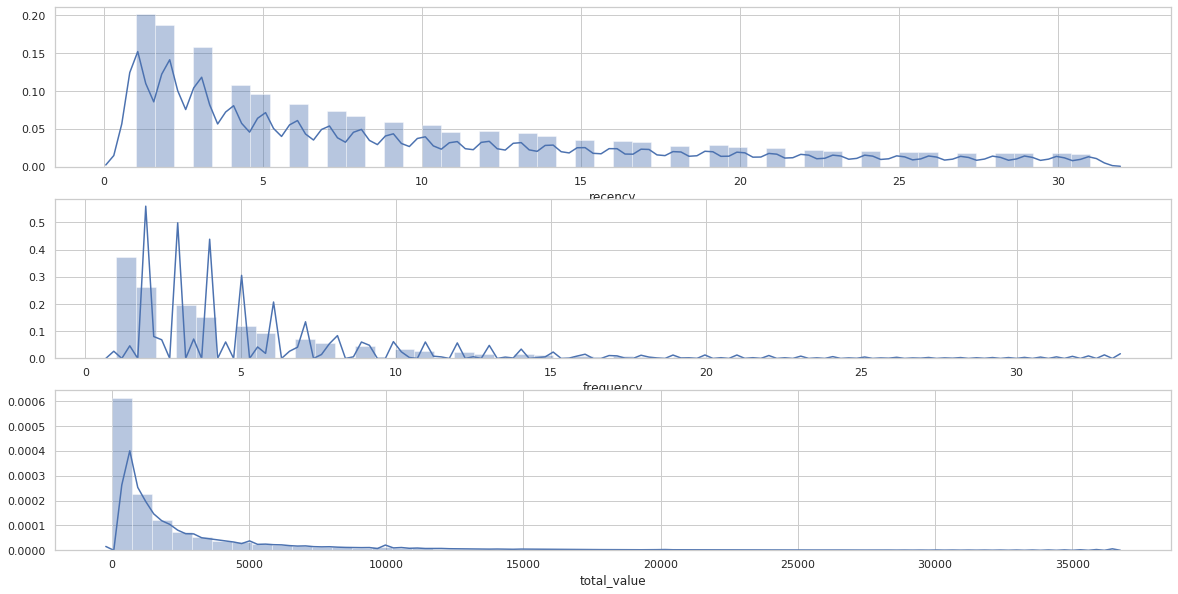

In [94]:
# Plot RFM distributions
plt.figure(figsize=(20,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(mixed_pdf['recency'])
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(mixed_pdf['frequency'])
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(mixed_pdf['total_value'])
# Show the plot
plt.show()

In [121]:
def compute_rfm_value(df, n=4):
    
    import numpy as np
    
    r_labels = range(n, 0, -1); 
    f_labels = range(1, n+1)
    r_groups = pd.qcut(df['recency'], q=n, labels=r_labels)
    f_groups = pd.qcut(df['frequency'], q=n, labels=f_labels)
    df = df.assign(R = r_groups.values, F = f_groups.values)
    
    m_labels = range(1, n+1)
    m_groups = pd.qcut(df['total_value'], q=n, labels=m_labels)
    df = df.assign(M = m_groups.values)
    
    def join_rfm(x): return int(str(x['R']) + str(x['F']) + str(x['M']))
    df['rfm'] = df.apply(join_rfm, axis=1)
    df['rfm_score'] = df[['R','F','M']].sum(axis=1)
    print(df.head())
    
    return df


In [105]:
rfm_value=compute_rfm_value(mixed_pdf)

  customer_id  frequency  recency  monetary_value  total_value     type  R  F  \
0    10000000          1       20      219.000000        219.0  classic  1  1   
1  1000000231          1       25       49.000000         49.0  classic  1  1   
2  1000000391          5       10      239.000000       1195.0  classic  2  3   
3  1000000402          3       30      150.333328        451.0  classic  1  2   
4  1000000522         11        1      369.272736       4062.0  classic  4  4   

   M  rfm  rfm_score  
0  1  111        3.0  
1  1  111        3.0  
2  3  233        8.0  
3  2  122        5.0  
4  4  444       12.0  


In [106]:
rfm_value[rfm_value['type'] == 'model'].describe()

,frequency,recency,monetary_value,total_value,rfm,rfm_score
count,1.515279e+06,1.515279e+06,1.515279e+06,1.515279e+06,1.515279e+06,1.515279e+06
mean,4.861297e+00,9.211867e+00,6.039169e+02,2.745769e+03,2.863293e+02,7.442056e+00
std,4.749762e+00,8.127618e+00,1.181315e+03,4.717044e+03,1.239880e+02,2.836578e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.110000e+02,3.000000e+00
25%,2.000000e+00,3.000000e+00,1.225556e+02,3.000000e+02,2.110000e+02,5.000000e+00
50%,3.000000e+00,6.000000e+00,2.490000e+02,9.460000e+02,3.110000e+02,7.000000e+00
75%,6.000000e+00,1.400000e+01,5.980000e+02,2.854575e+03,4.230000e+02,1.000000e+01
max,3.300000e+01,3.100000e+01,3.626180e+04,3.653800e+04,4.440000e+02,1.200000e+01


In [107]:
rfm_value[rfm_value['type'] == 'classic'].describe()

,frequency,recency,monetary_value,total_value,rfm,rfm_score
count,1.389142e+07,1.389142e+07,1.389142e+07,1.389142e+07,1.389142e+07,1.389142e+07
mean,4.781738e+00,9.347670e+00,5.967970e+02,2.657652e+03,2.840731e+02,7.377439e+00
std,4.699332e+00,8.173536e+00,1.173657e+03,4.577545e+03,1.241571e+02,2.834467e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.110000e+02,3.000000e+00
25%,2.000000e+00,3.000000e+00,1.196000e+02,2.970000e+02,2.110000e+02,5.000000e+00
50%,3.000000e+00,7.000000e+00,2.490000e+02,9.050000e+02,2.440000e+02,7.000000e+00
75%,6.000000e+00,1.400000e+01,5.900000e+02,2.743000e+03,4.220000e+02,1.000000e+01
max,3.300000e+01,3.100000e+01,3.540000e+04,3.540234e+04,4.440000e+02,1.200000e+01


In [85]:
rfm_value['R'].value_counts()

4    4553569
1    3350929
3    2994506
2    2992412
Name: R, dtype: int64

In [86]:
rfm_value['F'].value_counts()

1    5645657
4    3263566
3    3239958
2    1742235
Name: F, dtype: int64

In [87]:
rfm_value['M'].value_counts()

1    3474280
4    3472822
3    3472491
2    3471823
Name: M, dtype: int64

# Validate lifecycle phases

In [ ]:
path2="s3a://midgar-aws-workspace/prod/shinra/modelling/journeyautomation/tenant/paytm-india/base/customerPhases/dt="

In [ ]:
#phase_map_dfs=map(lambda x: users.join(spark.read.parquet(path2+x).select("customer_id", "phase_id"), 
#                                       on=['customer_id']),
#               ['2020-05-19'])

In [ ]:
#phase_red_df=reduce(lambda x,y: x.union(y), phase_map_dfs)

In [ ]:
#phase_red_df=users.join(spark.read.parquet(path2+'2020-05-19').select("customer_id", "phase_id"), 
#                                       on=['customer_id'])

In [ ]:
phase_red_df=(spark.read.parquet(path2+'2020-05-19').select("customer_id", "phase_id"))

In [ ]:
sample_1000=user_phase_left.limit(1000).cache()
sample_1000.count()

In [ ]:
diff=sample_1000.join(phase_red_df, on=['customer_id', 'phase_id'], how='left_anti')

In [30]:
diff.count()